# Calcium Imaging in SMA and M1 of Macaques: Data Exploration and Analysis

> **DISCLAIMER**: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results.

This notebook provides an introduction to Dandiset 001174, which contains calcium imaging data from the supplementary motor area (SMA) and primary motor area (M1) in rhesus macaques. We'll explore the dataset structure, visualize regions of interest (ROIs), and analyze calcium activity patterns.

## Introduction

This Dandiset contains one-photon calcium imaging recordings from the supplementary motor (SMA) and primary motor (M1) areas in rhesus macaques. The researchers implanted gradient index (GRIN) lenses and expressed GCaMP6f to image calcium transients while the animals were at rest or engaged in an arm reaching task.

The study focuses on examining activity patterns of projection neurons in deep layers of these motor areas, tracking cell activity across conditions, examining cell pairs for synchronous activity, and assessing sequential activation patterns.

### Dandiset Information

- **Title**: Calcium imaging in SMA and M1 of macaques
- **Description**: The study of motor cortices in non-human primates is relevant to our understanding of human motor control, both in healthy conditions and in movement disorders. Calcium imaging and miniature microscopes allow the study of multiple genetically identified neurons with excellent spatial resolution. We used this method to examine activity patterns of projection neurons in deep layers of the supplementary motor (SMA) and primary motor areas (M1) in four rhesus macaques. We implanted gradient index lenses and expressed GCaMP6f to image calcium transients while the animals were at rest or engaged in an arm reaching task. We tracked the activity of SMA and M1 neurons across conditions, examined cell pairs for synchronous activity, and assessed whether SMA and M1 neuronal activation followed specific sequential activation patterns. We demonstrate the value of in vivo calcium imaging for studying patterns of activity in groups of corticofugal neurons in SMA and M1.
- **Identifier**: DANDI:001174
- **Contributors**: Galvan, Adriana; Martel, Anne-Caroline; Pittard, Damien; Devergnas, Annaelle; Risk, Benjamin; Nassi, Jonathan J.; Yu, Waylin; Downer, Joshua D. ; Wichmann, Thomas
- **Measurement Technique**: one-photon microscopy technique, analytical technique, surgical technique
- **Keywords**: One-photon calcium imaging, non-human primates, microendoscope, reaching task, neuronal coactivation, calcium sensors, GCaMP, GRIN lens

## Setup and Data Loading

Let's start by setting up our environment and loading the necessary packages. We'll use `pynwb` for working with the Neurodata Without Borders (NWB) files and `lindi` for remote file access.

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pynwb
import lindi
import seaborn as sns
from dandi.dandiapi import DandiAPIClient
from matplotlib.patches import Patch
import scipy.signal as signal

# Set up the visualization environment
sns.set_theme()
%matplotlib inline

## Accessing Dandiset Assets

Let's use the DANDI API to list all of the assets (NWB files) in this Dandiset:

In [2]:
from dandi.dandiapi import DandiAPIClient
client = DandiAPIClient()
dandiset = client.get_dandiset("001174")
assets = list(dandiset.get_assets())

# Print some information about the assets
print(f"Total number of assets: {len(assets)}")
print("\nSample of available NWB files:")
for i, asset in enumerate(assets[:10]):  # Show first 10 assets
    print(f"{i+1}. {asset.path} ({asset.size / (1024**3):.2f} GB)")

Total number of assets: 45

Sample of available NWB files:
1. sub-V/sub-V_ses-20230309T110929_ophys.nwb (9.93 GB)
2. sub-Q/sub-Q_ophys.nwb (0.74 GB)
3. sub-Q/sub-Q_ses-20220922T131747_ophys.nwb (0.73 GB)
4. sub-Q/sub-Q_ses-20221003T131952_ophys.nwb (1.58 GB)
5. sub-Q/sub-Q_ses-20221028T121142_ophys.nwb (1.45 GB)
6. sub-Q/sub-Q_ses-20221201T132256_ophys.nwb (1.54 GB)
7. sub-Q/sub-Q_ses-20221202T122907_ophys.nwb (1.46 GB)
8. sub-Q/sub-Q_ses-20221206T121002_ophys.nwb (23.39 GB)
9. sub-Q/sub-Q_ses-20220915T133954_ophys.nwb (1.10 GB)
10. sub-Q/sub-Q_ses-20221201T134628_ophys.nwb (0.78 GB)


## Exploring an NWB File

For this analysis, we'll focus on a calcium imaging session from subject Q. This file contains data recorded while the animal was engaged in an arm reaching task.

In [3]:
# Load the NWB file using lindi (remote file access)
# We're using asset 807851a7-ad52-4505-84ee-3b155a5bd2a3: sub-Q/sub-Q_ses-20220915T133954_ophys.nwb
nwb_file_url = "https://lindi.neurosift.org/dandi/dandisets/001174/assets/807851a7-ad52-4505-84ee-3b155a5bd2a3/nwb.lindi.json"

print("Loading NWB file...")
f = lindi.LindiH5pyFile.from_lindi_file(nwb_file_url)
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

Loading NWB file...


Now that we have loaded the NWB file, let's examine its basic information and structure.

In [4]:
# Print basic information about the NWB file
print(f"Session Description: {nwb.session_description}")
print(f"Identifier: {nwb.identifier}")
print(f"Session Start Time: {nwb.session_start_time}")
print(f"File Create Date: {nwb.file_create_date[0]}")
print("\nSubject Information:")
print(f"  Subject ID: {nwb.subject.subject_id}")
print(f"  Species: {nwb.subject.species}")
print(f"  Sex: {nwb.subject.sex}")
print(f"  Age: {nwb.subject.age}")

Session Description: Calcium imaging in SMA during the arm reaching condition
Identifier: a7bd67d8-614c-42aa-b07f-3ffd4b164e32
Session Start Time: 2022-09-15 13:39:54.612000+00:00
File Create Date: 2025-01-23 15:37:55.123079+00:00

Subject Information:
  Subject ID: Q
  Species: Macaca mulatta
  Sex: F
  Age: P5Y


## Data Structure

The NWB file contains the following main components:

1. **Raw calcium imaging data** (OnePhotonSeries): The raw frames collected during calcium imaging
2. **Fluorescence data** (Fluorescence/RoiResponseSeries): Fluorescence traces for each ROI
3. **Event Amplitude data** (EventAmplitude): Detected calcium events for each ROI
4. **ROI masks** (ImageSegmentation/PlaneSegmentation): The spatial footprints of the identified cells

Let's explore each of these components.

In [5]:
# Access the OnePhotonSeries data
one_photon_series = nwb.acquisition["OnePhotonSeries"]
print("OnePhotonSeries:")
print(f"  Shape: {one_photon_series.data.shape}")
print(f"  Data type: {one_photon_series.data.dtype}")
print(f"  Sampling rate: {one_photon_series.rate} Hz")
print(f"  Number of frames: {one_photon_series.data.shape[0]}")
print(f"  Frame dimensions: {one_photon_series.data.shape[1]}x{one_photon_series.data.shape[2]} pixels")

# Access the processing module
ophys = nwb.processing["ophys"]
print("\nProcessing module:")
print(f"  Description: {ophys.description}")
print(f"  Available interfaces: {list(ophys.data_interfaces.keys())}")

# Access fluorescence data
fluorescence = ophys["Fluorescence"]["RoiResponseSeries"]
print("\nFluorescence data:")
print(f"  Shape: {fluorescence.data.shape}")
print(f"  Number of ROIs: {fluorescence.data.shape[1]}")
print(f"  Sampling rate: {fluorescence.rate} Hz")

# Access event amplitude data
event_amplitude = ophys["EventAmplitude"]
print("\nEvent amplitude data:")
print(f"  Shape: {event_amplitude.data.shape}")
print(f"  Sampling rate: {event_amplitude.rate} Hz")

# Access ROI masks
plane_segmentation = ophys["ImageSegmentation"]["PlaneSegmentation"]
print("\nROI masks (image segmentation):")
print(f"  Number of ROIs: {len(plane_segmentation)}")
print(f"  Mask dimensions: {plane_segmentation['image_mask'].data.shape[1]}x{plane_segmentation['image_mask'].data.shape[2]} pixels")

OnePhotonSeries:
  Shape: (9041, 320, 200)
  Data type: uint16
  Sampling rate: 10.0 Hz
  Number of frames: 9041
  Frame dimensions: 320x200 pixels

Processing module:
  Description: Optical physiology data obtained by processing raw calcium imaging data
  Available interfaces: ['EventAmplitude', 'Fluorescence', 'ImageSegmentation']

Fluorescence data:
  Shape: (9041, 40)
  Number of ROIs: 40
  Sampling rate: 10.0 Hz

Event amplitude data:
  Shape: (9041, 40)
  Sampling rate: 10.003730030174271 Hz

ROI masks (image segmentation):
  Number of ROIs: 40
  Mask dimensions: 292x179 pixels


## Visualizing ROIs

Let's visualize the regions of interest (ROIs) identified in the calcium imaging data. Each ROI represents a single cell or neuron. We'll create a visualization of all ROIs to understand their spatial organization.

Number of ROIs (cells): 40
Mask dimensions: 292 x 179 pixels


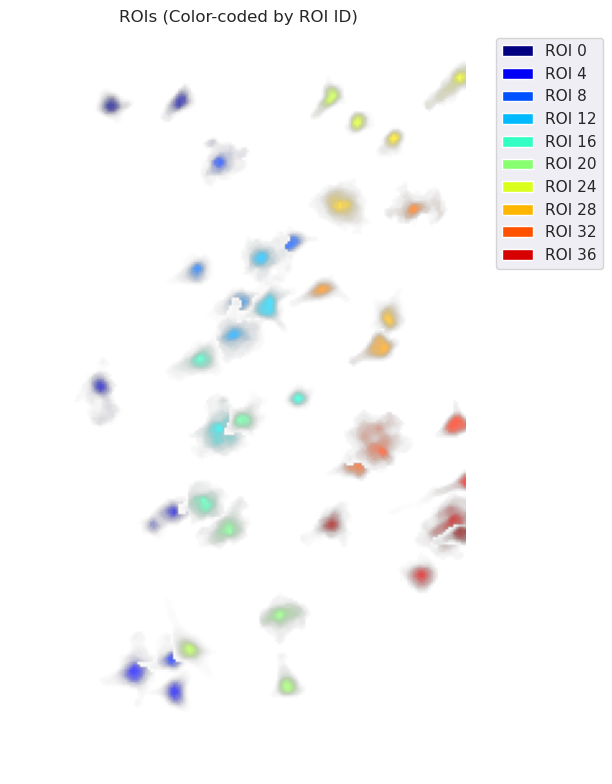

In [6]:
# Get all ROI masks
roi_masks = plane_segmentation["image_mask"].data[:]  # Get all ROI masks
num_rois = roi_masks.shape[0]
print(f"Number of ROIs (cells): {num_rois}")
print(f"Mask dimensions: {roi_masks.shape[1]} x {roi_masks.shape[2]} pixels")

# Create a figure with color-coded ROIs
plt.figure(figsize=(10, 8))

# Create a colormap for the ROIs
colors = plt.cm.jet(np.linspace(0, 1, num_rois))

# Create a color-coded mask
colored_mask = np.zeros((roi_masks.shape[1], roi_masks.shape[2], 4))
for i in range(num_rois):
    # Create an RGBA array for this ROI
    roi_rgba = np.zeros((roi_masks.shape[1], roi_masks.shape[2], 4))
    # Set the RGB values based on the color from the colormap
    roi_rgba[..., 0] = colors[i, 0] * roi_masks[i]
    roi_rgba[..., 1] = colors[i, 1] * roi_masks[i]
    roi_rgba[..., 2] = colors[i, 2] * roi_masks[i]
    roi_rgba[..., 3] = roi_masks[i] * 0.7  # Alpha (transparency)
    
    # Add this ROI to the combined mask
    # Only update pixels where this ROI has data
    mask = roi_masks[i] > 0
    colored_mask[mask] = roi_rgba[mask]

# Display the combined color-coded mask
plt.imshow(colored_mask)
plt.title('ROIs (Color-coded by ROI ID)')
plt.axis('off')

# Create a legend with a subset of ROIs to avoid overcrowding
legend_elements = []
step = max(1, num_rois // 10)  # Show about 10 ROIs in the legend
for i in range(0, num_rois, step):
    legend_elements.append(Patch(facecolor=colors[i], label=f'ROI {i}'))
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

The above visualization shows the spatial distribution of ROIs (neurons) in the field of view. Each colored region represents a different cell, with colors assigned based on ROI ID. We can observe that:

- The ROIs are distributed non-uniformly across the field of view
- There are clusters of ROIs in certain areas, which might represent functional groups
- The ROIs vary in size and shape, reflecting the morphological diversity of the imaged neurons

Let's also visualize the ROI density to see where we have higher concentrations of cells:

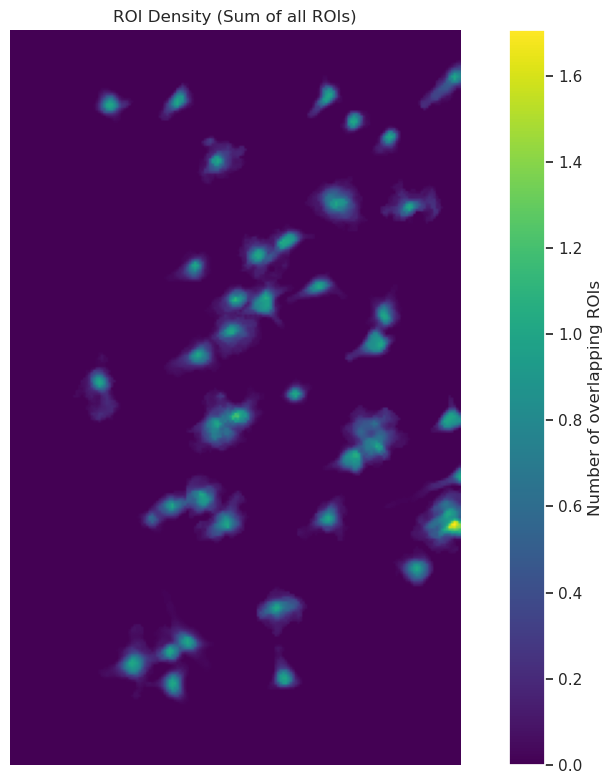

In [7]:
# Create a heatmap showing all ROIs combined (for density visualization)
plt.figure(figsize=(10, 8))
heatmap = np.sum(roi_masks, axis=0)  # Sum across all ROIs
im = plt.imshow(heatmap, cmap='viridis')
plt.title('ROI Density (Sum of all ROIs)')
plt.colorbar(im, label='Number of overlapping ROIs')
plt.axis('off')
plt.tight_layout()

This heatmap shows the density of ROIs across the field of view. Brighter areas indicate regions with more ROIs or overlapping ROIs. This visualization can help identify areas with higher concentrations of cells.

Let's examine a single ROI to understand their typical structure:

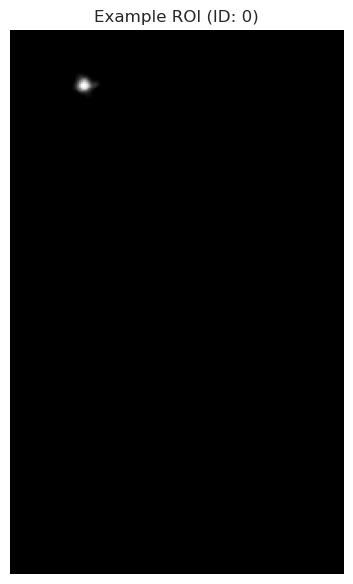

In [8]:
# Display the first ROI
plt.figure(figsize=(8, 6))
plt.imshow(roi_masks[0], cmap='gray')
plt.title(f'Example ROI (ID: 0)')
plt.axis('off')
plt.tight_layout()

This image shows a single ROI (Region of Interest). ROIs typically correspond to individual neurons in calcium imaging data. They're identified through a segmentation process that isolates spatially distinct regions with correlated pixel intensity changes over time.

## Visualizing Raw Calcium Imaging Data

Now, let's visualize some raw calcium imaging frames to understand what the data looks like before processing:

Total number of frames: 9041
Sampling frames at indices: [0, 2260, 4520, 6780, 9040]


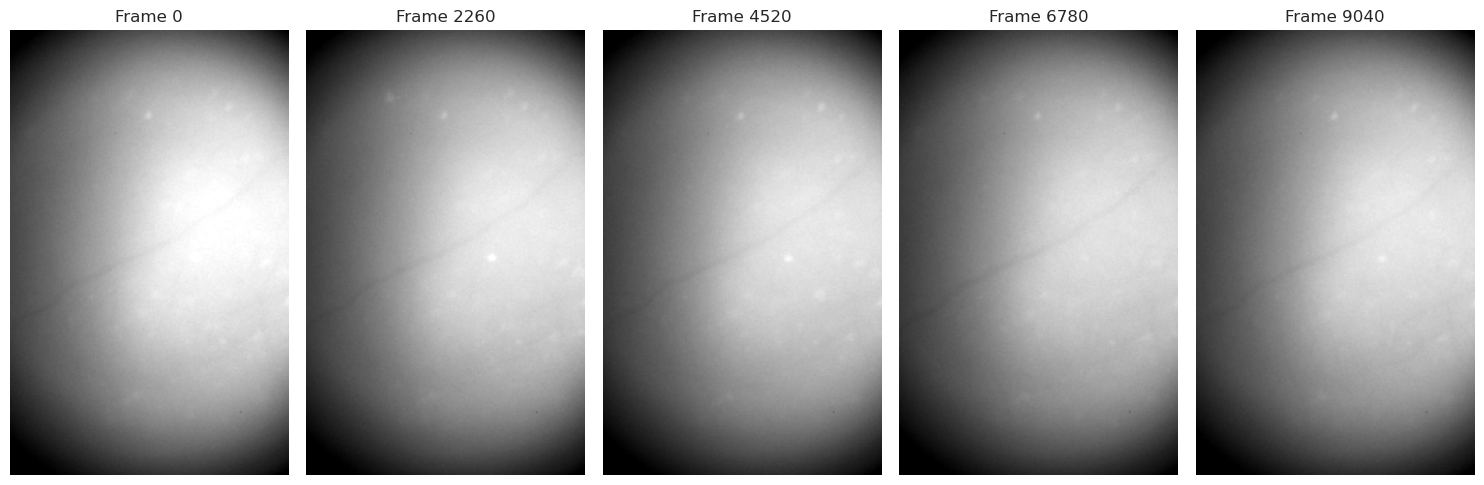

In [9]:
# Sample a few frames from different time points
num_frames = one_photon_series.data.shape[0]
sample_indices = [0, num_frames//4, num_frames//2, 3*num_frames//4, num_frames-1]

print(f"Total number of frames: {num_frames}")
print(f"Sampling frames at indices: {sample_indices}")

# Create a figure to display the sample frames
fig, axes = plt.subplots(1, len(sample_indices), figsize=(15, 5))
vmin, vmax = None, None  # Will be computed from the first frame

# Load frames from various timepoints
for i, idx in enumerate(sample_indices):
    # Load the frame data
    frame = one_photon_series.data[idx, :, :]
    
    # For the first frame, compute reasonable min/max values
    if i == 0:
        # Use percentiles to avoid extreme outliers
        vmin = np.percentile(frame, 1)
        vmax = np.percentile(frame, 99)
    
    # Display the frame
    im = axes[i].imshow(frame, cmap='gray', vmin=vmin, vmax=vmax)
    axes[i].set_title(f"Frame {idx}")
    axes[i].axis('off')

plt.tight_layout()

These images show raw calcium imaging frames from different timepoints in the recording. The bright spots likely represent cells with calcium activity. The raw data typically shows:

- Bright regions representing active neurons (where calcium concentration is high)
- Background fluorescence from non-neuronal tissue and out-of-focus cells
- Potential motion artifacts and uneven illumination

Let's visualize a single frame with ROI centers overlaid to see the relationship between the raw data and the identified cells:

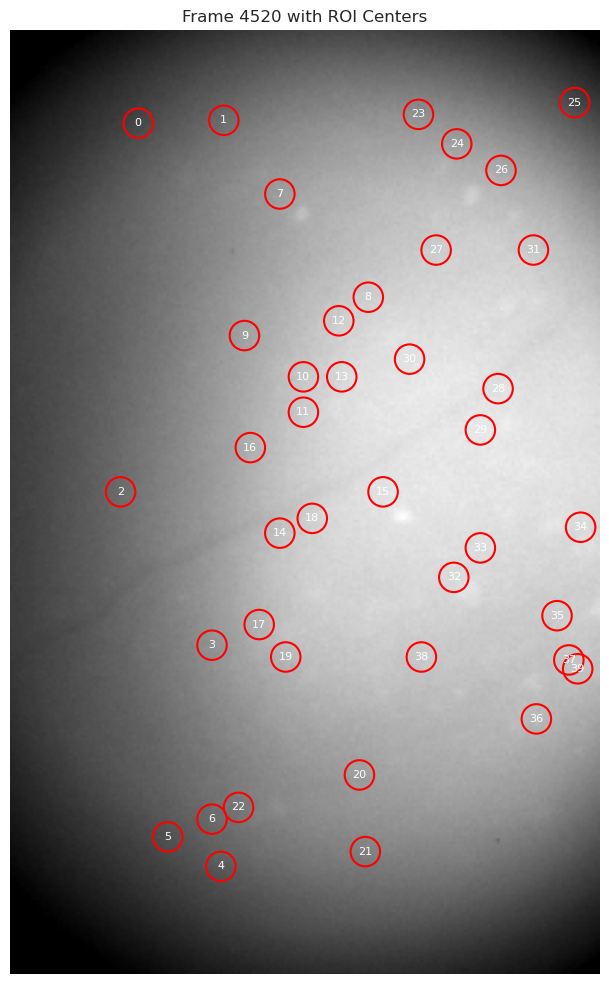

In [10]:
# Choose a middle frame
middle_frame_idx = num_frames // 2
middle_frame = one_photon_series.data[middle_frame_idx, :, :]

# Create a figure with the raw frame and ROI centers
plt.figure(figsize=(12, 10))

# Display the raw frame
plt.imshow(middle_frame, cmap='gray', vmin=vmin, vmax=vmax)

# Overlay ROI centers
for i in range(roi_masks.shape[0]):
    # Get the binary mask
    mask = roi_masks[i]
    
    # For visualization only, we'll just use the center coordinates to mark ROIs
    if mask.max() > 0:  # ensure the mask isn't empty
        # Get mask centroid (approximate)
        coords = np.where(mask > 0)
        if len(coords[0]) > 0:  # Check there are indeed coordinates
            y_center = int(np.mean(coords[0]))
            x_center = int(np.mean(coords[1]))
            
            # Scale to match frame dimensions if needed
            scale_y = middle_frame.shape[0] / mask.shape[0]
            scale_x = middle_frame.shape[1] / mask.shape[1]
            
            y_center_scaled = int(y_center * scale_y)
            x_center_scaled = int(x_center * scale_x)
            
            # Draw a circle at the ROI center
            circle = plt.Circle((x_center_scaled, y_center_scaled), 5, color='red', fill=False, linewidth=1.5)
            plt.gca().add_patch(circle)
            
            # Add ROI number
            plt.text(x_center_scaled, y_center_scaled, str(i), color='white', 
                     fontsize=8, ha='center', va='center')

plt.title(f"Frame {middle_frame_idx} with ROI Centers")
plt.axis('off')
plt.tight_layout()

This visualization shows how the identified ROIs align with the raw calcium imaging data. The red circles indicate the centers of each ROI, with the ROI ID shown as a number. Note that there may be some misalignment between the ROI masks and the raw frames due to slight differences in dimensions.

## Analyzing Calcium Activity

Now, let's analyze the calcium activity traces for the identified ROIs. We'll examine both the fluorescence data and the detected events to understand the neural activity patterns.

In [11]:
# Access the fluorescence data
fluor_data = fluorescence.data[:]  # Load the entire dataset
sampling_rate = fluorescence.rate  # Hz

# Access the event amplitude data
event_data = event_amplitude.data[:]  # Load the entire dataset

print(f"Fluorescence data shape: {fluor_data.shape}")
print(f"Event data shape: {event_data.shape}")
print(f"Sampling rate: {sampling_rate} Hz")

# Calculate the timestamps (in seconds)
num_samples = fluor_data.shape[0]
timestamps = np.arange(num_samples) / sampling_rate
duration_min = timestamps[-1] / 60  # Convert to minutes
print(f"Recording duration: {duration_min:.2f} minutes")

Fluorescence data shape: (9041, 40)
Event data shape: (9041, 40)
Sampling rate: 10.0 Hz
Recording duration: 15.07 minutes


Let's visualize the calcium activity traces for a few selected ROIs to understand their temporal dynamics:

Total ROIs: 40
Selected ROIs for visualization: [ 0  4  8 13 17 21 26 30 34 39]


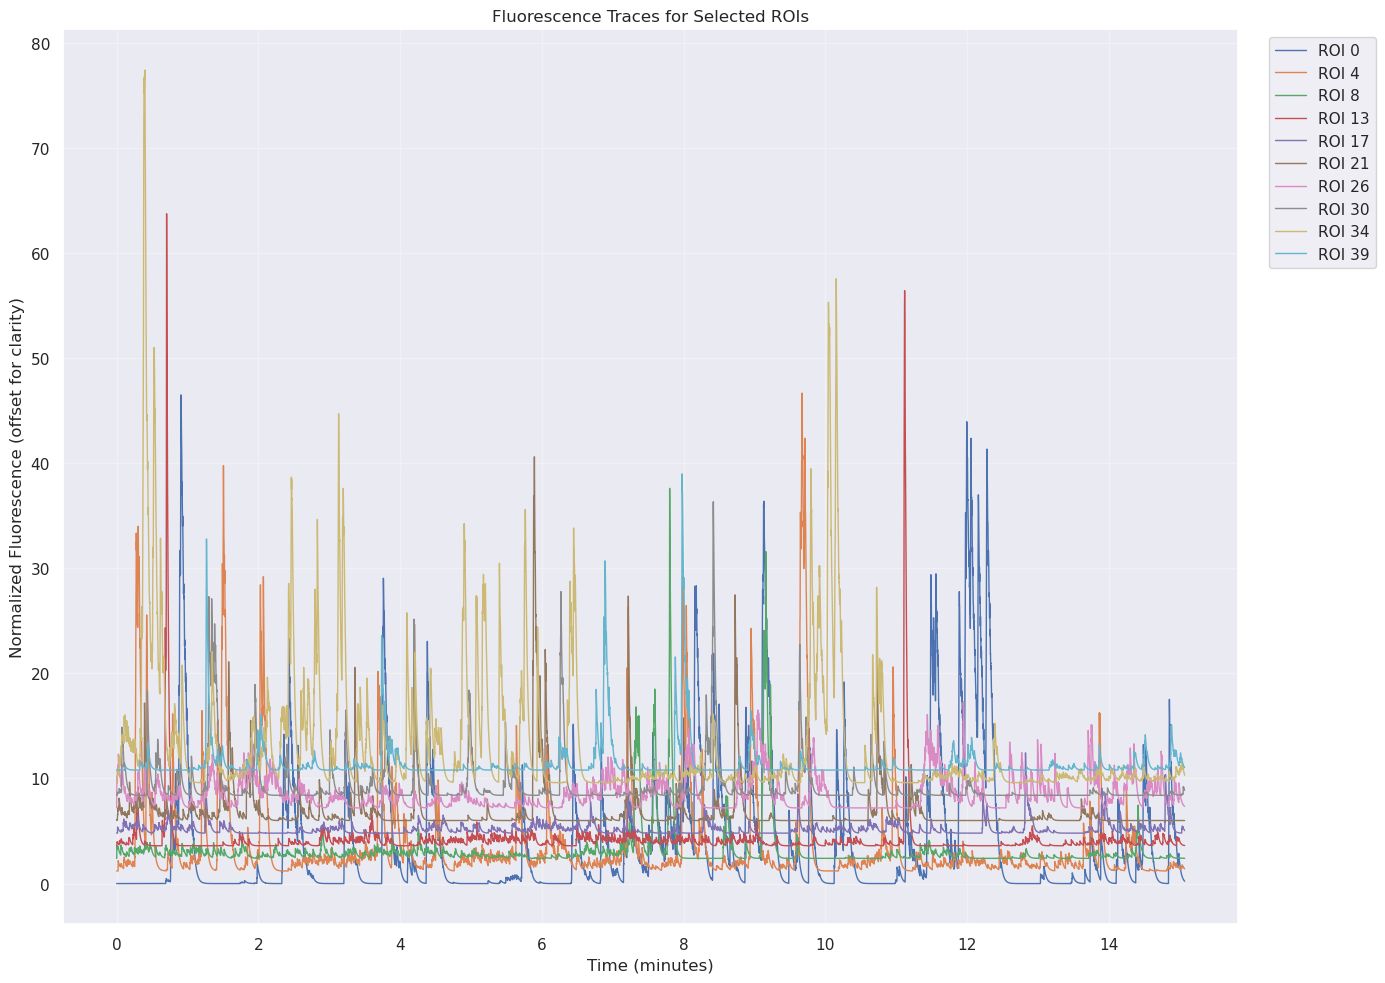

In [12]:
# Select a subset of ROIs for visualization (to avoid overcrowding)
num_rois = fluor_data.shape[1]
roi_subset = np.linspace(0, num_rois-1, min(10, num_rois), dtype=int)  # Up to 10 ROIs evenly spaced

print(f"Total ROIs: {num_rois}")
print(f"Selected ROIs for visualization: {roi_subset}")

# Create a figure for the selected ROI traces
plt.figure(figsize=(14, 10))

# Plot fluorescence traces for the selected ROIs
for i, roi_id in enumerate(roi_subset):
    # Normalize the trace for better visualization
    trace = fluor_data[:, roi_id]
    trace_norm = (trace - np.min(trace)) / (np.max(trace) - np.min(trace)) if np.max(trace) > np.min(trace) else trace
    
    # Offset the trace for visualization
    trace_offset = trace_norm + i * 1.2
    
    # Plot the trace
    plt.plot(timestamps / 60, trace_offset, lw=1, label=f'ROI {roi_id}')

plt.xlabel('Time (minutes)')
plt.ylabel('Normalized Fluorescence (offset for clarity)')
plt.title('Fluorescence Traces for Selected ROIs')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

The above plot shows normalized fluorescence traces for several ROIs, stacked vertically for clarity. Each trace represents the calcium activity of a single neuron over time. Peaks in these traces correspond to calcium transients, which are indicative of neural activity (action potentials).

Now, let's compare fluorescence traces with event amplitudes for a few selected ROIs to understand how detected events correspond to calcium transients:

Selected ROIs for detailed comparison: [0, 21, 39]


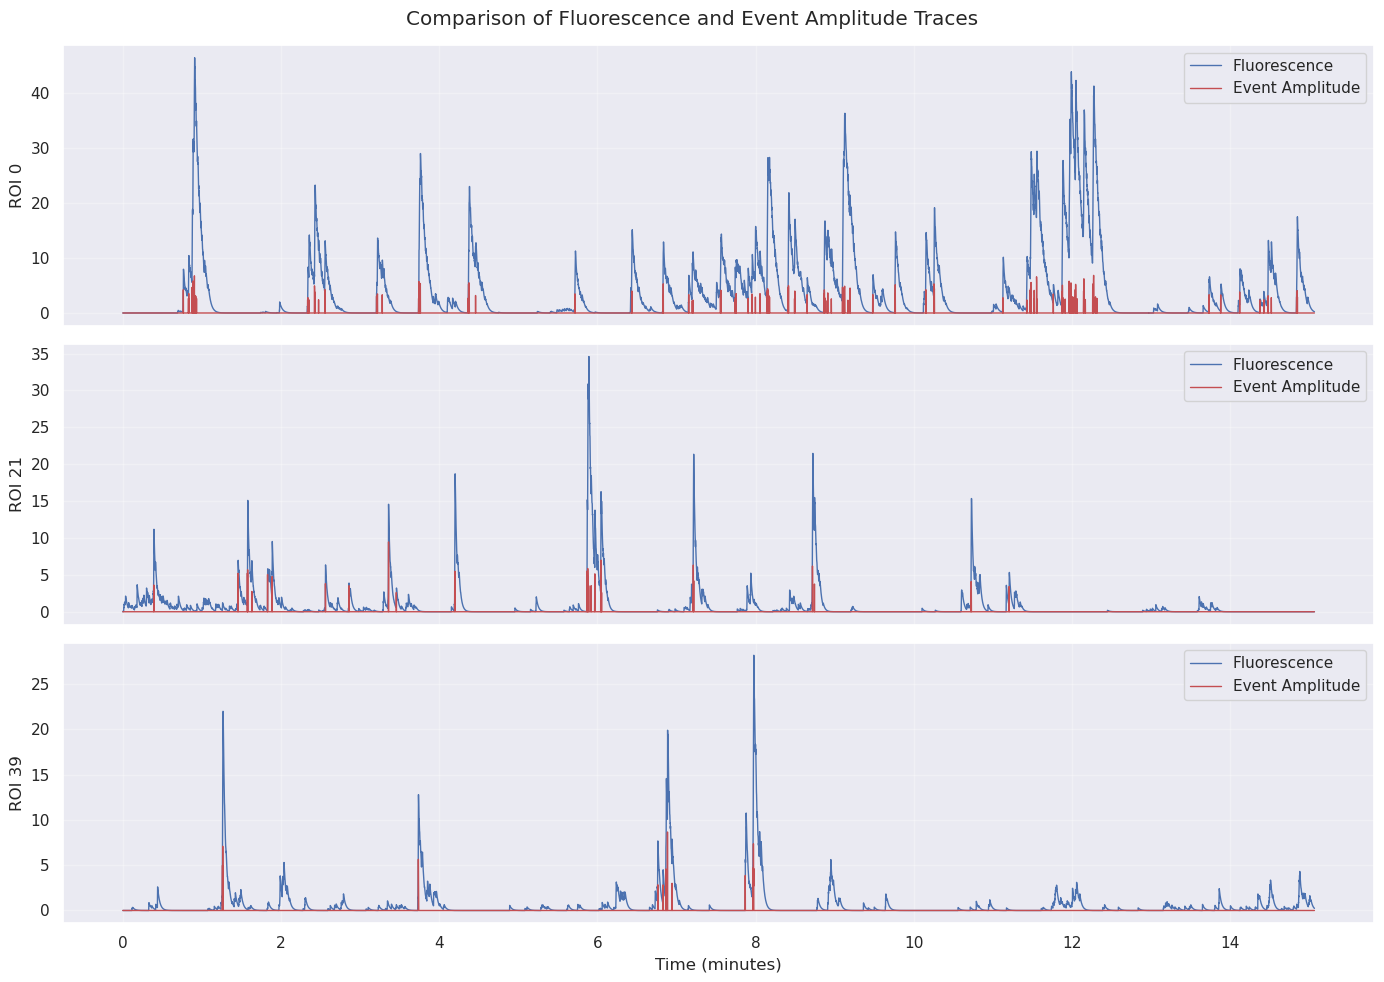

In [13]:
# Create a figure to compare fluorescence and event data for a few selected ROIs
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Choose 3 ROIs that may have interesting activity patterns
interesting_rois = [roi_subset[0], roi_subset[len(roi_subset)//2], roi_subset[-1]]
print(f"Selected ROIs for detailed comparison: {interesting_rois}")

for i, roi_id in enumerate(interesting_rois):
    ax = axes[i]
    
    # Plot fluorescence trace
    fluor_trace = fluor_data[:, roi_id]
    ax.plot(timestamps / 60, fluor_trace, 'b-', lw=1, label='Fluorescence')
    
    # Plot event amplitudes
    event_trace = event_data[:, roi_id]
    ax.plot(timestamps / 60, event_trace, 'r-', lw=1, label='Event Amplitude')
    
    ax.set_ylabel(f'ROI {roi_id}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (minutes)')
plt.suptitle('Comparison of Fluorescence and Event Amplitude Traces')
plt.tight_layout()

This visualization compares the raw fluorescence traces (blue) with the detected event amplitudes (red) for three selected ROIs. Event amplitudes typically represent detected calcium transients, which correspond to neural activity. We can observe:

- The event amplitudes (red) align with peaks in the fluorescence traces (blue) 
- Not all fluctuations in the fluorescence signal are detected as events
- Different ROIs show distinct activity patterns, with varying frequency and amplitude of calcium events

Let's create a raster plot to visualize the activity across all ROIs simultaneously:

Event threshold: 0.0000
Number of detected events: 2021


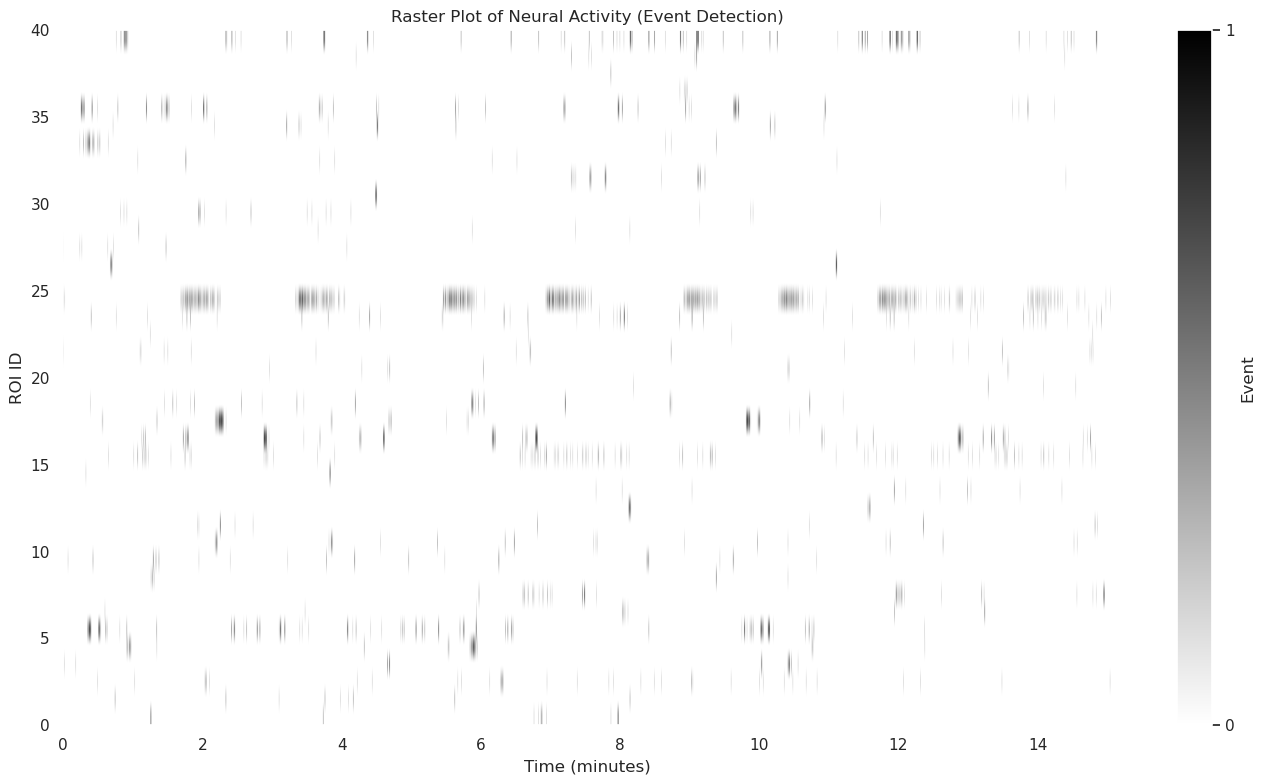

In [14]:
# Create a binary event matrix (1 if event, 0 if no event)
# Use a threshold based on percentile of event amplitudes
event_threshold = np.percentile(event_data, 90)  # Top 10% are considered events
event_binary = event_data > event_threshold
print(f"Event threshold: {event_threshold:.4f}")
print(f"Number of detected events: {np.sum(event_binary)}")

# Create a raster plot
plt.figure(figsize=(14, 8))
plt.imshow(event_binary.T, aspect='auto', cmap='binary', 
           extent=[0, duration_min, 0, num_rois])

plt.xlabel('Time (minutes)')
plt.ylabel('ROI ID')
plt.title('Raster Plot of Neural Activity (Event Detection)')
plt.colorbar(label='Event', ticks=[0, 1])
plt.grid(False)
plt.tight_layout()

This raster plot provides a comprehensive view of activity across all ROIs over time. Each horizontal line represents an ROI, and each white dot represents a detected calcium event (neural activity). This visualization allows us to identify:

- Periods of high or low overall activity
- Synchronized activity across multiple ROIs
- ROIs that are consistently more or less active than others
- Temporal patterns in the neural activity

## Cross-Correlation Analysis

Finally, let's analyze temporal relationships between ROIs by computing cross-correlations between pairs of ROIs:

/opt/conda/lib/python3.11/site-packages/scipy/signal/_signaltools.py:247: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2), mode, method)


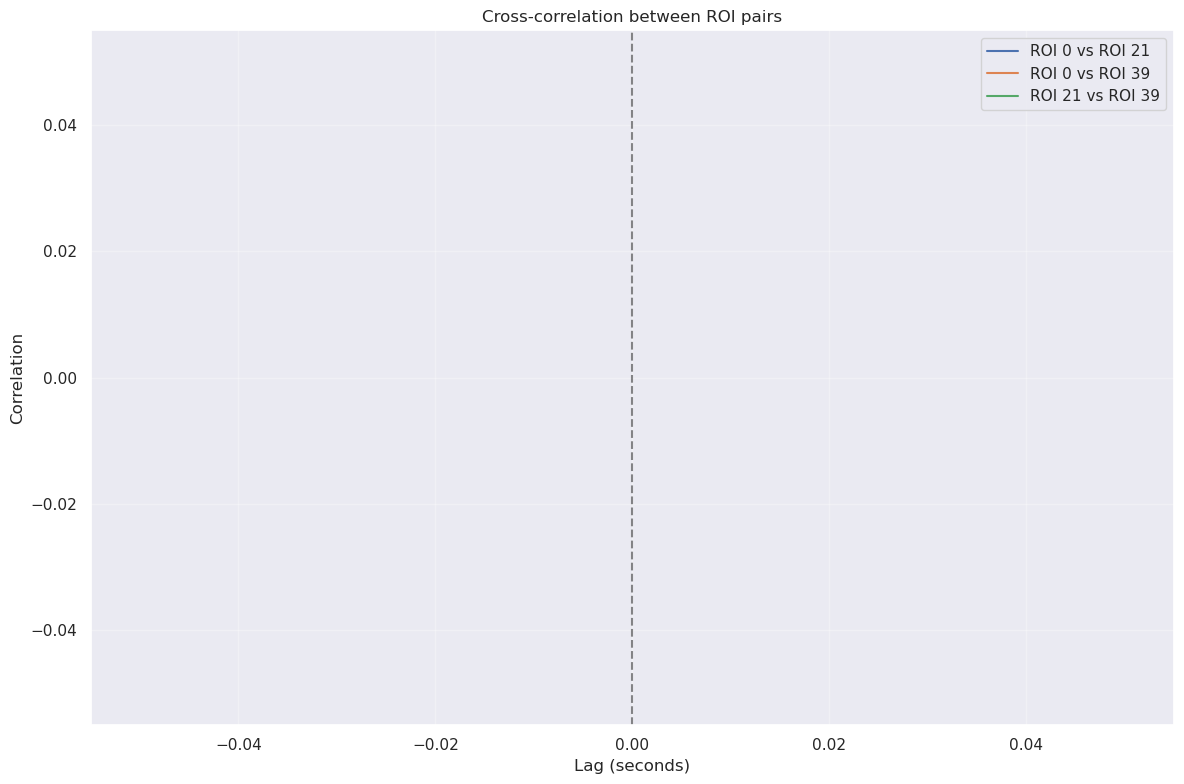

In [15]:
# Calculate and plot cross-correlations between some ROIs
plt.figure(figsize=(12, 8))

# Choose a few ROIs for correlation analysis
corr_rois = interesting_rois
max_lag = int(5 * sampling_rate)  # 5 seconds max lag
lags = np.arange(-max_lag, max_lag + 1) / sampling_rate  # Convert to seconds

for i in range(len(corr_rois)):
    for j in range(i+1, len(corr_rois)):
        roi1_id = corr_rois[i]
        roi2_id = corr_rois[j]
        
        # Get the traces
        trace1 = fluor_data[:, roi1_id] - np.mean(fluor_data[:, roi1_id])
        trace2 = fluor_data[:, roi2_id] - np.mean(fluor_data[:, roi2_id])
        
        # Calculate cross-correlation
        xcorr = signal.correlate(trace1, trace2, mode='full')
        xcorr /= np.sqrt(np.sum(trace1**2) * np.sum(trace2**2))  # Normalize
        
        # Plot
        plt.plot(lags, xcorr[len(trace1)-max_lag-1:len(trace1)+max_lag], 
                 label=f'ROI {roi1_id} vs ROI {roi2_id}')

plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Lag (seconds)')
plt.ylabel('Correlation')
plt.title('Cross-correlation between ROI pairs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

This cross-correlation plot shows temporal relationships between pairs of ROIs. A peak at a non-zero lag would suggest that activity in one ROI consistently leads or follows activity in another ROI, which could indicate functional connectivity. The cross-correlation analysis can reveal:

- Whether pairs of ROIs have correlated activity
- If there are time delays in the correlated activity
- The strength and direction of potential functional connections between neurons

## Summary

In this notebook, we've explored calcium imaging data from the supplementary motor area (SMA) and primary motor area (M1) in rhesus macaques. We've:

1. Loaded and examined NWB file structure and metadata
2. Visualized regions of interest (ROIs) representing individual neurons
3. Explored raw calcium imaging data
4. Analyzed fluorescence traces and detected events
5. Created raster plots to visualize activity across all neurons
6. Performed cross-correlation analysis to examine functional relationships between neurons

This dataset provides valuable insights into the activity patterns of neurons in motor cortices in non-human primates, which can enhance our understanding of motor control in both healthy conditions and movement disorders.

## Next Steps

To further explore this dataset, researchers might:

1. Apply additional analyses such as dimensionality reduction (PCA, t-SNE) to identify population-level activity patterns
2. Correlate neural activity with behavioral variables (e.g., arm movements during reaching tasks)
3. Compare activity patterns between SMA and M1, and between different experimental conditions
4. Investigate temporal sequences in neural activation
5. Analyze the spatial organization of functionally related neurons

## References

- Dandiset 001174: [https://dandiarchive.org/dandiset/001174/](https://dandiarchive.org/dandiset/001174/)
- DANDI Archive: [https://dandiarchive.org/](https://dandiarchive.org/)
- Pynwb Documentation: [https://pynwb.readthedocs.io/](https://pynwb.readthedocs.io/)